In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from pymongo import MongoClient
from bson.objectid import ObjectId
import time,datetime
conn = MongoClient()
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    data = [d for d in cursor]
    # print('In',str(col))
    count = 0
    for dic in data:
#         if 'o2_value' and 'hr_value' in dic.keys():
#             if (dic['longitude'] != 0) and (dic['longitude'] != '') and (dic['latitude'] != '') \
#                             and (dic['o2_value'] != '') and (dic['hr_value']!= ''):
        if 'hr_value' in dic.keys():
            if dic['hr_value']  != '':
                clean_data.append(dic)

In [3]:
import os 
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt

In [4]:
clean_data[0]

{'_id': ObjectId('5c88be22c4e5a626a3d9e610'),
 'hour': 16,
 'year': 2019,
 'hr_value': '67',
 'step_value': '0',
 'longitude': '',
 'minute': 24,
 'second': 0,
 'latitude': '',
 'month': 3,
 'day': 13,
 'o2_value': '96',
 'timestamp': 1552465440.0}

In [42]:
for i, line in enumerate(clean_data):
    for j, (key, value) in enumerate(line.items()):
        print(j , key, value)
    break

0 _id 5c88be22c4e5a626a3d9e610
1 hour 16
2 year 2019
3 hr_value 67
4 step_value 0
5 longitude 
6 minute 24
7 second 0
8 latitude 
9 month 3
10 day 13
11 o2_value 96
12 timestamp 1552465440.0


In [7]:
float_data = np.zeros((len(clean_data),1))
dic = {3:0, 4:1, 5:2, 8:3, 11:4, 12: 5}
for i, line in enumerate(clean_data):
    for j, (key, value) in enumerate(line.items()):
        if j in [3]:
            if value != '':
                float_data[i,dic[j]] = float(value)
            else:
                float_data[i,dic[j]] = 0

In [8]:
len(clean_data)

13054

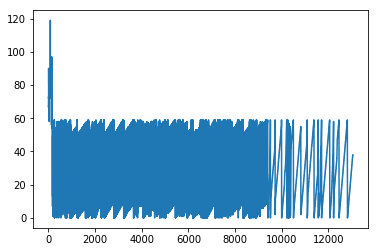

In [12]:
temp = float_data[:,0]
plt.plot(range(len(temp)), temp)

In [23]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of the pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [24]:
print(float_data.shape)
float_data = float_data.reshape(len(float_data),)
print(float_data.shape)
print(float_data[:10])

(13054,)
(13054,)
[67. 67. 67. 73. 73. 73. 73. 73. 72. 90.]


In [41]:
X, y = split_sequence(float_data, 3)
print(X.shape, y.shape)
X_LSTM = X.reshape((X.shape[0], X.shape[1], 1))
print(X_LSTM.shape)

(13051, 3) (13051,)
(13051, 3, 1)


In [27]:
for i in range(10):
    print(X[i], y[i])

[67. 67. 67.] 73.0
[67. 67. 73.] 73.0
[67. 73. 73.] 73.0
[73. 73. 73.] 73.0
[73. 73. 73.] 73.0
[73. 73. 73.] 72.0
[73. 73. 72.] 90.0
[73. 72. 90.] 79.0
[72. 90. 79.] 78.0
[90. 79. 78.] 80.0


In [30]:
from keras.models import Sequential
from keras import layers

In [37]:
n_steps = 3
model = Sequential()
model.add(layers.Dense(100, activation='relu', input_dim=n_steps))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, verbose=0)

In [39]:
x_input = np.array([97,98,96])
x_input = x_input.reshape((1, n_steps))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[88.48395]]


In [43]:
for i, line in enumerate(clean_data):
    for j, (key, value) in enumerate(line.items()):
        print(j , key, value)
    break

0 _id 5c88be22c4e5a626a3d9e610
1 hour 16
2 year 2019
3 hr_value 67
4 step_value 0
5 longitude 
6 minute 24
7 second 0
8 latitude 
9 month 3
10 day 13
11 o2_value 96
12 timestamp 1552465440.0


In [52]:
float_hr = np.zeros((len(clean_data),1))
float_o2 = np.zeros((len(clean_data),1))
# dic = {3:0, 4:1, 5:2, 8:3, 11:4, 12: 5}
for i, line in enumerate(clean_data):
    for j, (key, value) in enumerate(line.items()):
        if j is 3:
            if value != '':
                float_hr[i,0]=float(value)
            else:
                float_hr[i,0]= 0
        elif j is 11:
            if value != '':
                float_o2[i,0]=float(value)
            else:
                float_o2[i,0]= 0

In [60]:
out_seq = np.array([(float_hr[x], float_o2[x]) for x in range(len(float_o2))])
print(float_hr.shape)
print(out_seq.shape)
print(out_seq[0])

(13054, 1)
(13054, 2, 1)
[[67.]
 [96.]]


In [66]:
float_hr = float_hr.reshape((len(float_hr), 1))
float_o2 = float_o2.reshape((len(float_o2), 1))
out_seq = out_seq.reshape((len(out_seq), 2))
dataset  = np.hstack((float_hr, float_o2, out_seq))
print(dataset[:10])

[[67. 96. 67. 96.]
 [67. 96. 67. 96.]
 [67. 96. 67. 96.]
 [73. 97. 73. 97.]
 [73. 97. 73. 97.]
 [73. 97. 73. 97.]
 [73. 97. 73. 97.]
 [73. 97. 73. 97.]
 [72. 96. 72. 96.]
 [90. 98. 90. 98.]]


In [120]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences)-1:
            break
        seq_x, seq_y = sequences[i:end_ix, :-2], sequences[end_ix, :-2]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [130]:
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
for i in range(5, 10):
    print(X[i], y[i])

(13051, 3, 2) (13051, 2)
[[73. 97.]
 [73. 97.]
 [73. 97.]] [72. 96.]
[[73. 97.]
 [73. 97.]
 [72. 96.]] [90. 98.]
[[73. 97.]
 [72. 96.]
 [90. 98.]] [79. 98.]
[[72. 96.]
 [90. 98.]
 [79. 98.]] [78. 97.]
[[90. 98.]
 [79. 98.]
 [78. 97.]] [80. 97.]


In [131]:
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
n_ouput = y.shape[1]

In [132]:
model = Sequential()
model.add(layers.Dense(100, activation='relu', input_dim=n_input))
model.add(layers.Dense(n_ouput))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, verbose=0)

In [136]:
x_input = np.array([[73., 97.],[73., 97.], [73., 97.]])
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[73.276505 97.779594]]
